# 信用卡欺骗预测
## 数据预处理
考虑到数据集较大，项目采用Intel OneAPI开发的modin模块，选择dask engine。对数据集进行如下处理：
- 对数据缺失以及数据重复值进行清洗工作；
- 进行特征相关性分析以及特征选取
- 针对样本不平衡进行过采样

### 数据清洗

缺失值统计：
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
重复值统计：


False    283726
True       1081
Name: count, dtype: int64
数据类别分布：
Fraud Cases: 492
Valid Transactions: 284315


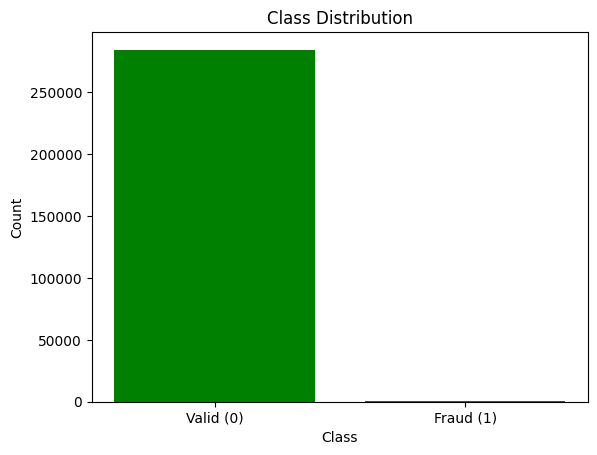

In [4]:
import modin.pandas as pd
import modin.config as modin_cfg
# import unidist.config as unidist_cfg
import matplotlib.pyplot as plt
import seaborn as sns

modin_cfg.Engine.put('dask') # Modin will use Unidist
# unidist_cfg.Backend.put('mpi') # Unidist will use MPI backend

data = pd.read_csv("creditcard.csv") # 请替换为你的文件路径

# 检查缺失值
print("缺失值统计：")
print(data.isnull().sum())

# 检查重复值
print("重复值统计：")
print(data.duplicated().value_counts())

print("数据类别分布：")
fraud = data[data['Class']== 1] 
valid = data[data['Class']== 0]
print('Fraud Cases: {}'.format(len(data[data['Class']==1])))
print('Valid Transactions: {}'.format(len(data[data['Class']==0])))
class_counts = data['Class'].value_counts()

# Plot the bar chart
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(class_counts.index, ['Valid (0)', 'Fraud (1)'])
plt.show()


从打印结果来看，没有缺失数据，但是有1081条重复数据，并且数据严重不平衡（将在下面解决），下面我们首先进行重复数据清洗

In [5]:
data.drop_duplicates(inplace=True)
data.duplicated().value_counts()

False    283726
Name: count, dtype: int64

### 特征选取


In [6]:
data.corr().Class.sort_values(ascending=False)

Class     1.000000
V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
V22       0.004887
V26       0.004265
V25       0.003202
V15      -0.003300
V13      -0.003897
V23      -0.006333
V24      -0.007210
Time     -0.012359
V6       -0.043915
V5       -0.087812
V9       -0.094021
V1       -0.094486
V18      -0.105340
V7       -0.172347
V3       -0.182322
V16      -0.187186
V10      -0.206971
V12      -0.250711
V14      -0.293375
V17      -0.313498
Name: Class, dtype: float64

基于相关性小于0.1、特征语义信息以及实际中欺骗行为与特征的联系综合考虑，除去V13、V15、V26、Time四个特征（移除过多特征将可能丢失原数据集的重要信息），并对Amount进行标准化


In [7]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['V13', 'V15', 'V26', 'Time','Amount'], axis=1)
data.index = range(len(data))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### 对样本过采样

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 获取除目标变量外的所有特征列
selected_features = data.columns[data.columns != 'Class'].tolist()

# 保留筛选后的特征和目标变量
data = data[selected_features + ['Class']]


# 分割特征和目标变量
X = data.drop('Class', axis=1)
y = data['Class']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化过采样器
oversampler = RandomOverSampler(sampling_strategy='minority')

# 进行过采样
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

print("类别分布（过采样后）:")
print(pd.Series(y_resampled).value_counts())

类别分布（过采样后）:


Class
0    198269
1    198269
Name: count, dtype: int64


## 模型训练
结合课堂所学分析比较下面3种模型：逻辑回归、随机森林和XGBoost的预测效果，并采用Intel® Extension for Scikit-learn的scikit-learn-intelex模块以及Intel-optimized XGBoost加速模型训练
### 逻辑回归预测

In [30]:
from timeit import default_timer as timer
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
#使用加速工具
from sklearnex import patch_sklearn
patch_sklearn()

# 创建逻辑回归模型
logistic_model = LogisticRegression()

# 训练模型
start = timer()
logistic_model.fit(X_resampled, y_resampled)
train_time = timer() - start
f"Intel® extension for Scikit-learn time: {train_time:.2f} s"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


'Intel® extension for Scikit-learn time: 0.42 s'

AUC-PR（Area Under the Precision-Recall Curve）是 Precision-Recall 曲线下的面积，用于评估二元分类器的性能。Precision-Recall 曲线显示在不同概率阈值下模型的精确性和召回率之间的权衡,计算AUPRC并绘制精确率-召回率曲线


AUC-PR: 0.69
Best Threshold: 1.00
Best Precision: 0.82
Best Recall: 0.72
Best F1 Score: 0.77


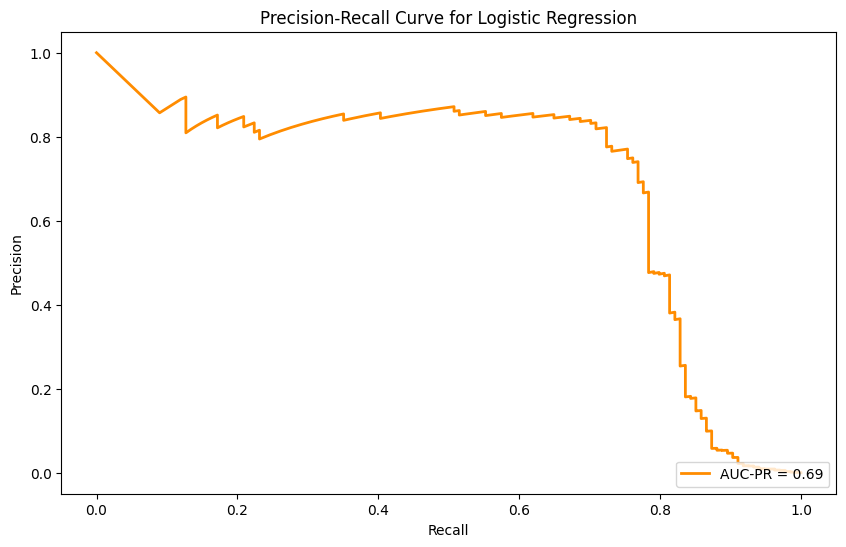

In [60]:
from sklearn.metrics import accuracy_score
import numpy as np

# 在测试集上进行预测
y_pred_logistic = logistic_model.predict(X_test)

# 获取逻辑回归预测概率
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

# 计算 Precision-Recall Curve
precision_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_test, y_prob_logistic)

# 计算 AUC-PR
auc_pr_logistic = auc(recall_logistic, precision_logistic)

# 计算 F1 分数
f1_score_logistic = 2 * (precision_logistic * recall_logistic) / (precision_logistic + recall_logistic)

# 获取达到最大 F1 分数的索引
best_f1_index_logistic = np.argmax(f1_score_logistic)

# 获取最佳阈值、Precision、Recall 和 F1 分数
best_threshold_logistic = thresholds_logistic[best_f1_index_logistic]
best_precision_logistic = precision_logistic[best_f1_index_logistic]
best_recall_logistic = recall_logistic[best_f1_index_logistic]
best_f1_logistic = f1_score_logistic[best_f1_index_logistic]

# 打印结果
print(f"\nAUC-PR: {auc_pr_logistic:.2f}")
print(f"Best Threshold: {best_threshold_logistic:.2f}")
print(f"Best Precision: {best_precision_logistic:.2f}")
print(f"Best Recall: {best_recall_logistic:.2f}")
print(f"Best F1 Score: {best_f1_logistic:.2f}")

# 可视化 Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_logistic, precision_logistic, color='darkorange', lw=2, label=f'AUC-PR = {auc_pr_logistic:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


### 随机森林预测

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Intel® extension for Scikit-learn time: 2.87 s



AUC-PR: 0.83
Best Threshold: 0.44
Best Precision: 0.92
Best Recall: 0.78
Best F1 Score: 0.85


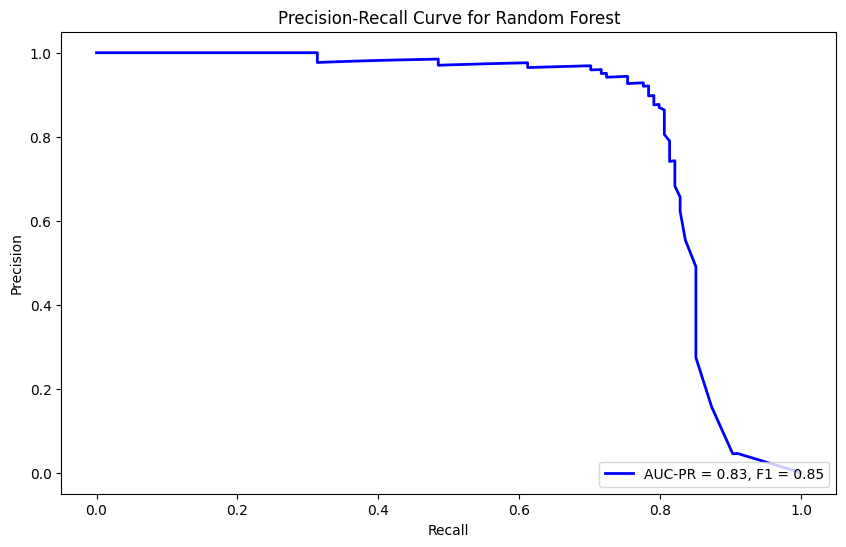

In [61]:
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# 初始化随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 使用过采样后的数据进行训练
# 使用加速工具
from sklearnex import patch_sklearn
patch_sklearn()
start = timer()
rf_model.fit(X_resampled, y_resampled)
train_time = timer() - start
print(f"Intel® extension for Scikit-learn time: {train_time:.2f} s")

# 预测概率
y_rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 计算 AUPRC
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_rf_pred_proba)
auc_pr_rf = auc(recall_rf, precision_rf)

# 计算 F1 分数
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)
best_f1_rf = np.max(f1_rf)

# 获取达到最大 F1 分数的索引
best_f1_index_rf = np.argmax(f1_rf)
best_threshold_rf = thresholds_rf[best_f1_index_rf]
best_precision_rf = precision_rf[best_f1_index_rf]
best_recall_rf = recall_rf[best_f1_index_rf]

# 打印结果
print(f"\nAUC-PR: {auc_pr_rf:.2f}")
print(f"Best Threshold: {best_threshold_rf:.2f}")
print(f"Best Precision: {best_precision_rf:.2f}")
print(f"Best Recall: {best_recall_rf:.2f}")
print(f"Best F1 Score: {best_f1_rf:.2f}")

# 可视化精确率-召回率曲线
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'AUC-PR = {auc_pr_rf:.2f}, F1 = {best_f1_rf:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

### XGBoost预测

AUC-PR for XGBoost: 0.74
F1 Score for XGBoost: 0.81


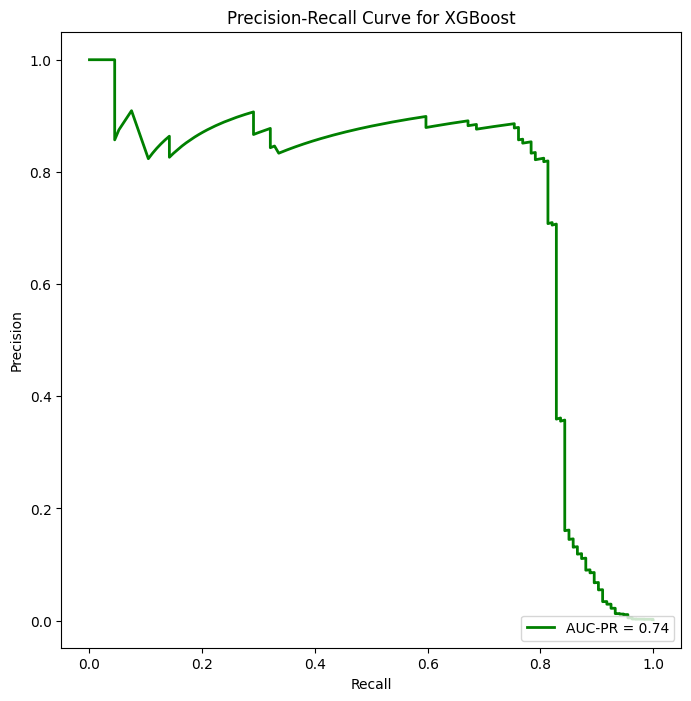

In [70]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_resampled, label= y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置模型训练参数
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

# 模型训练
num_round = 100
bst = xgb.train(params, dtrain, num_round)

y_pred_proba_xgb = bst.predict(dtest)

precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)

auc_pr_xgb = auc(recall_xgb, precision_xgb)

f1_threshold = thresholds_xgb[np.argmax(2 * precision_xgb * recall_xgb / (precision_xgb + recall_xgb))]
y_pred_binary_xgb = (y_pred_proba_xgb > f1_threshold).astype(int)
f1_xgb = f1_score(y_test, y_pred_binary_xgb)


print(f'AUC-PR for XGBoost: {auc_pr_xgb:.2f}')
print(f'F1 Score for XGBoost: {f1_xgb:.2f}')

plt.figure(figsize=(8, 8))
plt.plot(recall_xgb, precision_xgb, color='green', lw=2, label=f'AUC-PR = {auc_pr_xgb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

